In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [5]:

documents = [
    "This is a list which containig sample documents.",
    "Keywords are important for keyword-based search.",
    "Document analysis involves extracting keywords.",
    "Keyword-based search relies on sparse embeddings."
]

In [7]:

query="keyword-based search"

import re
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text


preprocess_documents=[preprocess_text(doc) for doc in documents]
     

print("Preprocessed Documents:")
for doc in preprocess_documents:
    print(doc)


print("Preprocessed Query:")
print(query)


preprocessed_query = preprocess_text(query)


preprocessed_query


Preprocessed Documents:
this is a list which containig sample documents
keywords are important for keywordbased search
document analysis involves extracting keywords
keywordbased search relies on sparse embeddings
Preprocessed Query:
keyword-based search


'keywordbased search'

In [8]:
vector=TfidfVectorizer()

X=vector.fit_transform(preprocess_documents)
X.toarray()

array([[0.        , 0.        , 0.37796447, 0.        , 0.37796447,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.37796447, 0.        , 0.        , 0.37796447, 0.        ,
        0.        , 0.37796447, 0.        , 0.        , 0.37796447,
        0.37796447],
       [0.        , 0.4533864 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.4533864 , 0.4533864 , 0.        ,
        0.        , 0.35745504, 0.35745504, 0.        , 0.        ,
        0.        , 0.        , 0.35745504, 0.        , 0.        ,
        0.        ],
       [0.46516193, 0.        , 0.        , 0.46516193, 0.        ,
        0.        , 0.46516193, 0.        , 0.        , 0.46516193,
        0.        , 0.        , 0.36673901, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.43671931, 0.        , 0.        , 0.       

In [9]:
query_embedding=vector.transform([preprocessed_query])


query_embedding.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.70710678, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.70710678, 0.        , 0.        ,
        0.        ]])

In [11]:

similarities = cosine_similarity(X, query_embedding)
np.argsort(similarities,axis=0)   
#ranked_documents = [documents[i] for i in ranked_indices]
     

#Ranking
ranked_indices=np.argsort(similarities,axis=0)[::-1].flatten()
     

ranked_indices


array([1, 3, 2, 0], dtype=int64)

In [13]:
ranked_documents = [documents[i] for i in ranked_indices]
# Output the ranked documents
for i, doc in enumerate(ranked_documents):
    print(f"Rank {i+1}: {doc}")

Rank 1: Keywords are important for keyword-based search.
Rank 2: Keyword-based search relies on sparse embeddings.
Rank 3: Document analysis involves extracting keywords.
Rank 4: This is a list which containig sample documents.


In [16]:
document_embeddings = np.array([
    [0.634, 0.234, 0.867, 0.042, 0.249],
    [0.123, 0.456, 0.789, 0.321, 0.654],
    [0.987, 0.654, 0.321, 0.123, 0.456]
])

# Sample search query (represented as a dense vector)
query_embedding = np.array([[0.789, 0.321, 0.654, 0.987, 0.123]])
     

# Calculate cosine similarity between query and documents
similarities = cosine_similarity(document_embeddings, query_embedding)



ranked_indices = np.argsort(similarities, axis=0)[::-1].flatten()
     

ranked_indices
     

array([0, 2, 1], dtype=int64)

In [2]:
import os 
import chromadb 
from langchain.vectorstores import Chroma 
from langchain.document_transformers import LongContextReorder 
from langchain.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceBgeEmbeddings 
from langchain.retrievers.merger_retriever import MergerRetriever 
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.retrievers import BM25Retriever,EnsembleRetriever

https://en.wikipedia.org/wiki/Okapi_BM25

In [3]:
%pip install --upgrade --quiet  rank_bm25

Note: you may need to restart the kernel to use updated packages.


In [17]:
from langchain_community.document_loaders import PyPDFLoader

In [18]:
doc_path = "data//english_paris_agreement.pdf" 

loader = PyPDFLoader(doc_path)

docs = loader.load()



In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=30)

chunks = splitter.split_documents(docs)

In [21]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-large-en"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

c:\Users\Administrator\miniconda3\envs\idk\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [22]:
from langchain.vectorstores import Chroma 

vectorstore = Chroma.from_documents(chunks,embeddings)

vectorstore_retriever = vectorstore.as_retriever(search_kwargs={"k":3})

In [23]:
from langchain.retrievers import BM25Retriever,EnsembleRetriever

In [25]:
keyword_retriever = BM25Retriever.from_documents(chunks)

keyword_retriever.k = 3

In [26]:
ensemble_retriever = EnsembleRetriever(retrievers=[vectorstore_retriever,keyword_retriever])

# Mixing vector search and keyword search for Hybrid search

hybrid_score = (1 — alpha) * sparse_score + alpha * dense_score

In [27]:


model_name = "HuggingFaceH4/zephyr-7b-beta"



In [28]:
import torch
from transformers import ( AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline, )
from langchain import HuggingFacePipeline

In [29]:
#function for loading 4-bit quanrized models 

def load_quantized_model(model_name: str):
    """
    model_name: Name or path of the model to be loaded.
    return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
    )
    return model


In [30]:
# initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    model_name: Name or path of the model for tokenizer initialization.
    return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

In [31]:
tokenizer = initialize_tokenizer(model_name)

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [32]:
model = load_quantized_model(model_name)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

RuntimeError: No GPU found. A GPU is needed for quantization.

In [ ]:
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    use_cache=True,
    device_map="auto",
    max_length=2048,
    do_sample=True,
    top_k=5,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

In [ ]:
llm = HuggingFacePipeline(pipeline=pipeline)


In [33]:
from langchain.chains import RetrievalQA

In [ ]:
normal_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=vectorstore_retreiver
)
     

hybrid_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=ensemble_retriever
)
     

response1 = normal_chain.invoke("What is Abstractive Question Answering?")

In [ ]:

print(response1.get("result"))

In [ ]:
response2 = hybrid_chain.invoke("What is Abstractive Question Answering?")
     

response2

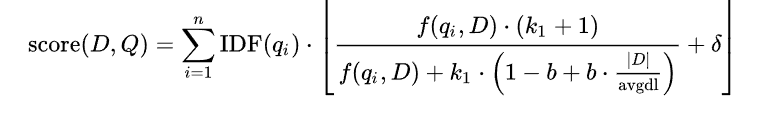

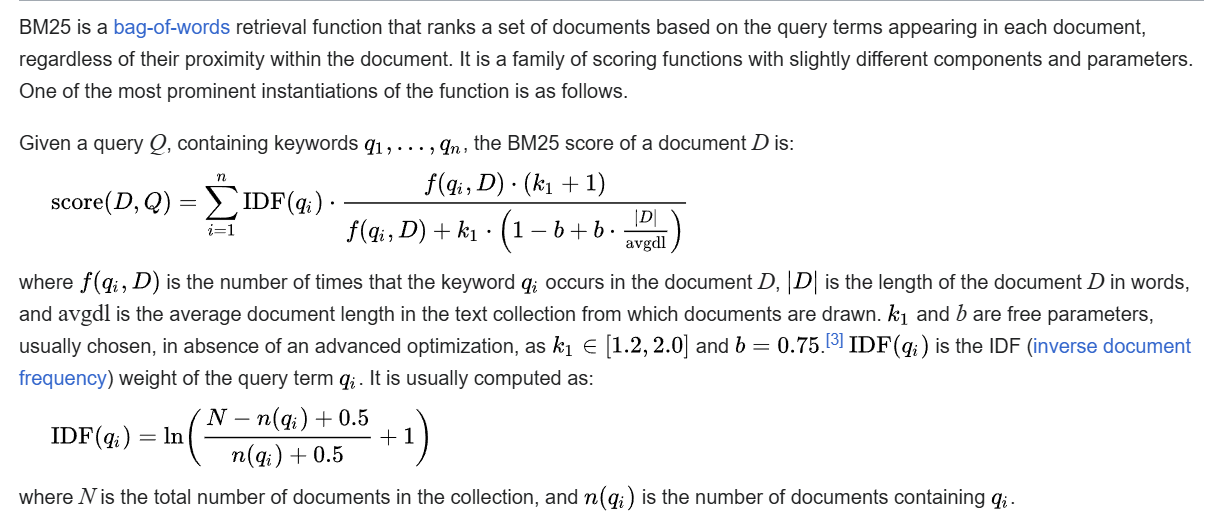